In [7]:
%matplotlib widget
import math
import numpy as np
from scipy.linalg import svd, block_diag
import matplotlib.pyplot as plt
from matplotlib import cycler
import pandas as pd
import seaborn as sns
import torch
import itertools
from flatten_dict import flatten, unflatten
import re
import importlib

import dd_analysis as dda
import familytree
english_tree = familytree.get_hinton_tree()

try:
    importlib.reload(util)
except NameError:
    import util
    
try:
    importlib.reload(net_analysis)
except NameError:
    import net_analysis
    
try:
    importlib.reload(pa)
except NameError:
    import problem_analysis as pa

report_titles = {
    'loss': 'Mean loss',
    'accuracy': 'Training sign accuracy',
    'weighted_acc': 'Training accuracy (weighted)',
    'weighted_acc_loose': 'Training sign accuracy (weighted)',
    'weighted_acc_loose_indomain': 'Training sign accuracy on same tree',
    'frac_perfect': 'Fraction perfect on training items',
    'test_accuracy': 'Test sign accuracy',
    'test_weighted_acc': 'Test sign accuracy (weighted)',
    'test_weighted_acc_indomain': 'Test sign accuracy on same tree',
    'test_frac_perfect': 'Fraction perfect on held-out items',
    'new_tree_etg': 'Epochs to learn new tree'
}

In [14]:
# Load data for analysis

try:
    curr_load_settings = load_settings
except NameError:
    curr_load_settings = {}
    
load_settings = {
    'dist_metric': 'euclidean',
    'corr_type': 'pearson',
    'compute_full_rdms': False,
    'include_individual_corr_mats': False,
    'include_individual_rdms': True,
    'subsample_snaps': 1
}

# cache already-loaded data
curr_res_paths = {}
if load_settings == curr_load_settings:
    try:
        curr_res_paths = res_paths
    except NameError:
        res_data = {}
else:
    res_data = {}
    
tree_holdout_shared_runs = {
    'english -> english': 'data/familytree/tree_ho/shared_english_to_english_leaky_res_2021-11-29_18-51-50.npz',
    'french -> english': 'data/familytree/tree_ho/shared_french_to_english_leaky_res_2021-11-30_00-10-47.npz',
    'english -> french': 'data/familytree/tree_ho/shared_english_to_french_leaky_res_2021-11-29_21-18-03.npz',
    'french -> french': 'data/familytree/tree_ho/shared_french_to_french_leaky_res_2021-11-30_02-18-13.npz'
}

tree_holdout_separate_runs = {
    'english -> english': 'data/familytree/tree_ho/separate_english_to_english_leaky_res_2021-11-30_06-59-09.npz',
    'french -> english': 'data/familytree/tree_ho/separate_french_to_english_leaky_res_2021-11-30_15-26-12.npz',
    'english -> french': 'data/familytree/tree_ho/separate_english_to_french_leaky_res_2021-11-30_11-04-33.npz',
    'french -> french': 'data/familytree/tree_ho/separate_french_to_french_leaky_res_2021-11-30_18-24-20.npz'
}

train2_holdout1_separate_runs = {
    'english -> english': 'data/final_runs/famnet_separate_english_to_english_res_2022-01-09_02-02-54.npz',
    'french -> english': 'data/final_runs/famnet_separate_french_to_english_res_2022-01-12_04-53-42.npz',
    'english -> french': 'data/final_runs/famnet_separate_english_to_french_res_2022-01-10_15-10-04.npz',
    'french -> french': 'data/final_runs/famnet_separate_french_to_french_res_2022-01-13_13-53-46.npz'
}

train2_holdout1_separate_noctloss_runs = {
    'english -> english': 'data/final_runs/famnet_separate_noctloss_english_to_english_res_2022-01-09_09-08-20.npz',
    'french -> english': 'data/final_runs/famnet_separate_noctloss_french_to_english_res_2022-01-12_14-01-01.npz',
    'english -> french': 'data/final_runs/famnet_separate_noctloss_english_to_french_res_2022-01-10_21-26-49.npz',
    'french -> french': 'data/final_runs/famnet_separate_noctloss_french_to_french_res_2022-01-13_20-32-23.npz'
}

res_paths = {
#     '2 trees, older params': 'data/familytree/new_params_res_2021-10-30_21-30-42.npz',
#     '1 tree, older params': 'data/familytree/new_params_1tree_res_2021-10-30_21-52-39.npz',
#     '2 trees': 'data/familytree/new_params_batch90_res_2021-11-12_13-57-53.npz',
#     '2 trees, no WD': 'data/familytree/batch90_noweightdecay_res_2021-11-11_19-58-44.npz',
#     '1 tree': 'data/familytree/batch90_1tree_res_2021-11-11_20-19-58.npz',
# #     '1 tree, double LR': 'data/familytree/batch90_1tree_doublelr_res_2021-11-11_20-41-19.npz',
#     '2 trees, separate relations': 'data/familytree/2tree_separate_rel_res_2021-11-12_10-19-31.npz',
#     '2 trees, separate, no WD': 'data/familytree/2tree_separate_rel_noweightdecay_res_2021-11-12_10-57-58.npz',
#     '1 tree, no WD': 'data/familytree/1tree_noweightdecay_res_2021-11-12_11-18-23.npz',
#     'Tree holdout (train 1, shared rels)': tree_holdout_shared_runs,
    'Tree holdout (train 1, separate rels)': tree_holdout_separate_runs,
    'Tree holdout (train 2, separate rels)': train2_holdout1_separate_runs,
    'Tree holdout (train 2, separate, no cross-tree loss)': train2_holdout1_separate_noctloss_runs,
    # 'Separate with P1 preact': 'data/familytree/p1_preact_lampinen_replication_res_2021-12-01_13-42-27.npz',
    # 'Shared with P1 preact': 'data/familytree/p1_preact_sharedrel_res_2021-12-02_12-56-42.npz'
}

res_paths_flat = flatten(res_paths, reducer='path')

# Avoid reloading data whenever possible
try:
    res_data_flat = {name: (res_data[name] if name in curr_res_paths and curr_res_paths[name] == path
                            else net_analysis.get_result_means(path, **load_settings))
                     for name, path in res_paths_flat.items()}
except:
    # Assume loading failed, revert
    res_paths = curr_res_paths
    raise
    
res_data = unflatten(res_data_flat, splitter='path')

In [15]:
# Get ready to look at particular runs
# curr_runs = ['2 trees', #'2 trees, no WD',
#              '2 trees, separate relations', #'2 trees, separate, no WD',
#              '1 tree', #'1 tree, no WD'
#             ]

curr_runs = ['Tree holdout (train 2, separate rels)', 'Tree holdout (train 2, separate, no cross-tree loss)']

curr_sets_nested = {name: res_data[name] for name in curr_runs if name in res_data.keys()}

# janky but this flattens only the entries of curr_sets_nested that are not already flat
curr_sets = {**flatten({k: v for k, v in curr_sets_nested.items() if 'snaps' not in v}, reducer='path', max_flatten_depth=2),
             **{k: v for k, v in curr_sets_nested.items() if 'snaps' in v}}

# get only the runs trained and tested on the same type
curr_sets = {k: v for k, v in curr_sets.items() if re.search(r'\W(\w+) [-=]+> \1', k)}

n_curr = len(curr_sets)


col_cycle = plt.rcParams['axes.prop_cycle']
line_cycle = cycler(linestyle=['-']) #, '--'])
prop_cycle_pairs = col_cycle * line_cycle

plt.close('all')

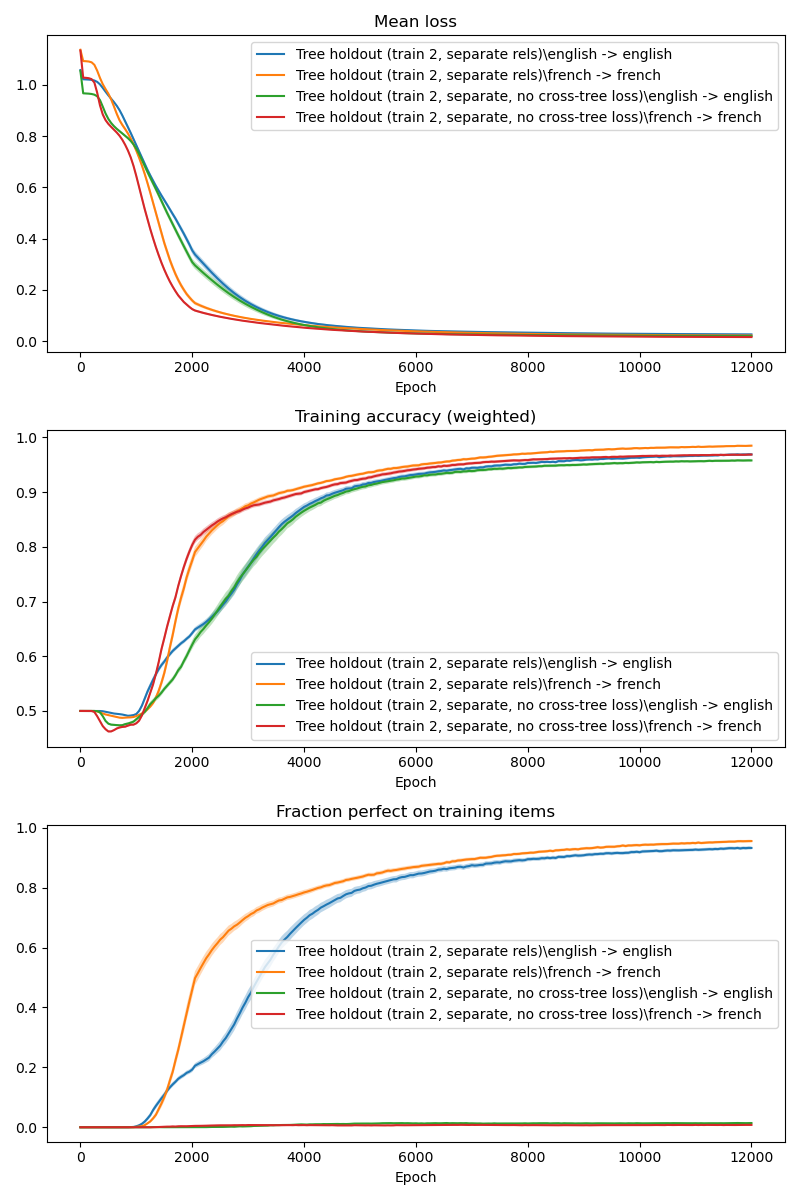

In [17]:
# Plot reports
report_types = ['loss', 'weighted_acc', 'frac_perfect', 'test_frac_perfect', 'test_weighted_acc']
report_types = list(filter(lambda t: t in next(iter(curr_sets.values()))['reports'], report_types))

fig, axs = util.make_plot_grid(len(report_types), 1, ax_dims=(8, 4), prop_cycle=prop_cycle_pairs)

for ax, rtype in zip(axs, report_types):
    for run_name, res in curr_sets.items():
        net_analysis.plot_report(ax, res, rtype, label=run_name, title=report_titles[rtype])
    ax.legend()
    
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
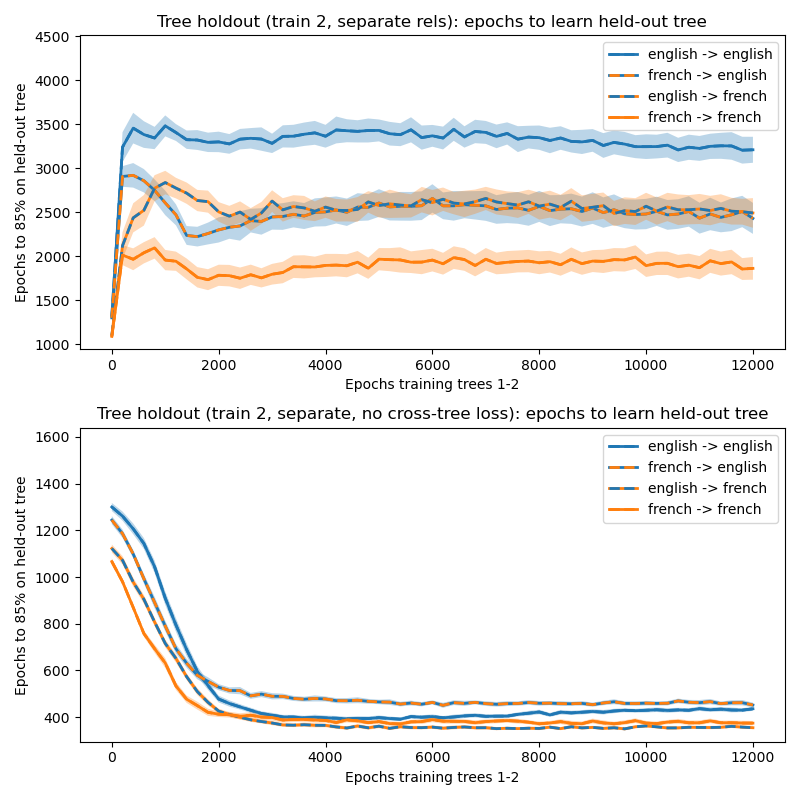

In [12]:
# Plot epochs-to-generalize, 1 plot per type of network

# Set color/line style cycle to highlight runs expected to have lower ETG
line_cycle = cycler(linestyle=['-', '--']) * 4  # first held-out, then trained-on
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'][:2])
color_inds = np.array([(ho, train) for ho in range(2) for train in range(2)]).ravel()
color_cycle = cycler(color=colors[color_inds])
prop_cycle = line_cycle + color_cycle

# A little hacky: assume any value of the runs dict with a length of 4 is a 2x2 train/test set of runs.
tree_holdout_runs = {key: runs for key, runs in curr_sets_nested.items() if len(runs) == 4}

n_types = len(tree_holdout_runs)
fig, axs = util.auto_subplots(n_types, 1, ax_dims=(8, 4), prop_cycle=prop_cycle)

for (label, runs), ax in zip(tree_holdout_runs.items(), axs.ravel()):
    h_lines = [[], []]  # first held-out, then trained-on
    ax.set_title(f'{label}: epochs to learn held-out tree')
    for run in runs.values():
        etg_epochs = run['etg_epochs']
        mean_etg = run['reports']['new_tree_etg']
        ci_etg = run['report_cis']['new_tree_etg']
        thresh_pct = run['train_params']['test_thresh'] * 100
        trained_trees = run['n_trained_domains']

        for line_list in h_lines:
            line_list.append(ax.plot(etg_epochs, mean_etg, lw=2)[0])
        ax.fill_between(etg_epochs, *ci_etg, alpha=0.3) # use "trained-on" color
        ax.fill_between([], []) # just advance patch cycle

    ax.legend(list(zip(*h_lines)), runs.keys())
    ax.set_xlabel(f'Epochs training first {trained_trees} trees')
    ax.set_ylabel(f'Epochs to {thresh_pct:g}% on held-out tree')
    
    curr_ylims = ax.get_ylim()
    ax.set_ylim((curr_ylims[0], curr_ylims[1] * 1.2))

fig.tight_layout()
plt.show()

In [107]:
# Plot how people map onto each representation layer unit (see Figure 6 in Hinton paper)
res_name = '2 trees'
run_num = 1
epoch = -1
snapshot = res_data[res_name]['snaps']['person1_repr'][run_num, epoch]
n_people, n_repr_units = snapshot.shape

fig, axs = util.make_plot_grid(n_repr_units, n_cols=2, ax_dims=(6, 2))

for unit_ind, (unit_snap, ax) in enumerate(zip(snapshot.T, axs)):
    im = util.imshow_pos(ax, unit_snap.reshape(2, -1))
    util.add_colorbar(im)
    ax.set_title(f'Unit {unit_ind + 1}')
    
    if n_repr_units - unit_ind <= 2:
        ax.set_xticks(range(n_people // 2))
        ax.set_xticklabels([p.name for p in english_tree.members], rotation=45, ha='right')
    else:
        ax.set_xticks([])
    
    if unit_ind % 2 == 0:
        ax.set_yticks(range(2))
        ax.set_yticklabels(['English', 'Italian'])
    else:
        ax.set_yticks([])
    
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
# Plot RDMs (at person representation layer)

total_snaps = min([sum(res['train_params']['num_epochs']) // res['train_params']['snap_freq'] for res in curr_sets.values()])
inds_to_plot = np.arange(0, total_snaps, 10)
layer = 'person1_repr'

layer_names = {
    'person1_repr': 'Person repr.',
    'person1_hidden': 'Person hidden repr.',
    'relation_repr': 'Relationship repr.',
    'relation_hidden': 'Relationship hidden repr.'
}

# print key
print('Name key')
print('--------')
for memb_ind, memb in enumerate(english_tree.members):
    print(f'{memb_ind:2}: {memb.name}')
print()

fig, axss = util.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(3, 3))
for ind, axs in zip(inds_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        res = curr_sets[label]
        if 'single_tree' in res['net_params']:
            family_strings = ['E'] if res['net_params']['single_tree'] else ['E', 'I']
        else:
            family_strings = [tree_name[0].upper() for tree_name in res['net_params']['trees']]
        person_labels = [f'{fam}{memb_ind}' for fam, memb_ind in itertools.product(family_strings, range(len(english_tree.members)))]
        
        if ind < len(res['snap_epochs']):
            net_analysis.plot_repr_corr(ax, res, layer, ind, person_labels, title_addon=f'{label}, {layer_names[layer]}')

fig.suptitle('Person representation correlation')
fig.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

Name key
--------
 0: Christopher
 1: Penelope
 2: Andrew
 3: Christine
 4: Margaret
 5: Arthur
 6: Victoria
 7: James
 8: Jennifer
 9: Charles
10: Colin
11: Charlotte



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [51]:
# Lampinen SVD analysis
def get_n_analogous_modes(res, n_shuffle=1000, plot_modes=False):
    use_flipped = not res['net_params']['share_rel_units']
    first_layer_weights = np.squeeze(res['snaps']['person1_repr_preact'][:, -1])  # n_runs x n_people x n_units
    n_runs, n_people, n_units = first_layer_weights.shape

    # permutation of people that flips the tree left/right without changing the structure (only for English/Italian tree).
    # Effectively exchanges everyone with their opposite-gender counterpart.
    flip_perm = [3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 11, 10]

    num_sig_modes = np.zeros(n_runs)
    num_sig_modes_flipped = np.zeros(n_runs) if use_flipped else None
    num_sig_modes_null = np.zeros(n_runs)

    def cross_tree_mode_corr(input_mode_mat):
        """Input is n_people x n_modes"""
        tree1_modes, tree2_modes = np.split(input_mode_mat, 2)
        return np.sum(tree1_modes * tree2_modes, axis=0)

    def get_n_sig_modes(this_mode_corr, shuffled_mode_corrs, alpha=0.05):
        """
        this_mode_corr: vector of correlations of input modes between two families
        shuffled_mode_corrs: n_shuffle x n_modes matrix of shuffled mode corrs
        """
        shuffled_greater_than_this = shuffled_mode_corrs > this_mode_corr
        this_mode_sig = np.sum(shuffled_greater_than_this, axis=0) < alpha * n_shuffle
        return np.sum(this_mode_sig)

    if plot_modes:
        fig, axs = util.make_plot_grid(6, 3, ravel=True)

    for k_run, weights in enumerate(first_layer_weights):
        input_modes = svd(weights, full_matrices=False)[0]

        shuffled_mode_corrs = np.stack([cross_tree_mode_corr(input_modes[util.choose_k_inds(n_people, n_people)]) for _ in range(n_shuffle)])

        real_mode_corr = cross_tree_mode_corr(input_modes)
        num_sig_modes[k_run] = get_n_sig_modes(real_mode_corr, shuffled_mode_corrs)

        input_modes_null = input_modes[util.choose_k_inds(n_people, n_people)]
        null_mode_corr = cross_tree_mode_corr(input_modes_null)
        num_sig_modes_null[k_run] = get_n_sig_modes(null_mode_corr, shuffled_mode_corrs)

        if use_flipped:
            input_modes_flipped = input_modes.copy()
            input_modes_flipped[:len(flip_perm)] = input_modes_flipped[flip_perm]
            flipped_mode_corr = cross_tree_mode_corr(input_modes_flipped)
            num_sig_modes_flipped[k_run] = get_n_sig_modes(flipped_mode_corr, shuffled_mode_corrs)

        if plot_modes and k_run < 6:
            util.imshow_centered_bipolar(axs[k_run], input_modes)
            axs[k_run].set_xlabel('Modes')
            axs[k_run].set_ylabel('People')
            axs[k_run].set_title(f'SVD input modes, run {k_run + 1}')

    if plot_modes:
        fig.tight_layout()
        plt.show()
    
    return num_sig_modes, num_sig_modes_flipped, num_sig_modes_null

n_sig_modes_separate, n_sig_modes_flipped_separate, n_sig_modes_null_separate = get_n_analogous_modes(curr_sets['Separate with P1 preact'], plot_modes=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
# Make violin plot of significantly analogous modes
num_modes_data = {
    'Regular': n_sig_modes_separate,
    'Flipped': n_sig_modes_flipped_separate,
    'Null Dist.': n_sig_modes_null_separate
}

df = pd.DataFrame(num_modes_data)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, inner='stick', ax=ax)
ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (separate relationships, 2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [52]:
# Make violin plot of significantly analogous modes
n_sig_modes_shared, _, n_sig_modes_null_shared = get_n_analogous_modes(curr_sets['Shared with P1 preact'])

num_modes_data = {
    'Regular': n_sig_modes_shared,
    'Null Dist.': n_sig_modes_null_shared
}

df = pd.DataFrame(num_modes_data)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, inner='stick', ax=ax)
ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (shared relationships, 2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
# Shared/separate combined plot

num_modes_data_full = {
    'Shared rels': n_sig_modes_shared,
    'Separate rels': n_sig_modes_separate + n_sig_modes_flipped_separate,
    'Null Dist.': np.concatenate([n_sig_modes_null_separate, n_sig_modes_null_shared])
}

dfs = [pd.DataFrame(data={'Analogy': label, 'NumModes': data}) for label, data in num_modes_data_full.items()]
df = pd.concat(dfs)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, x='Analogy', y='NumModes', inner='stick', ax=ax)
# ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

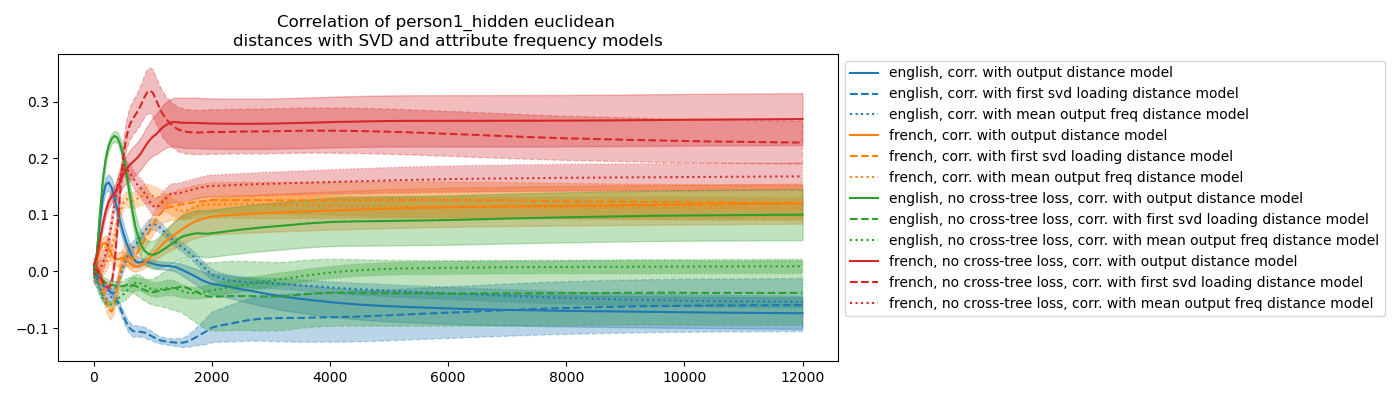

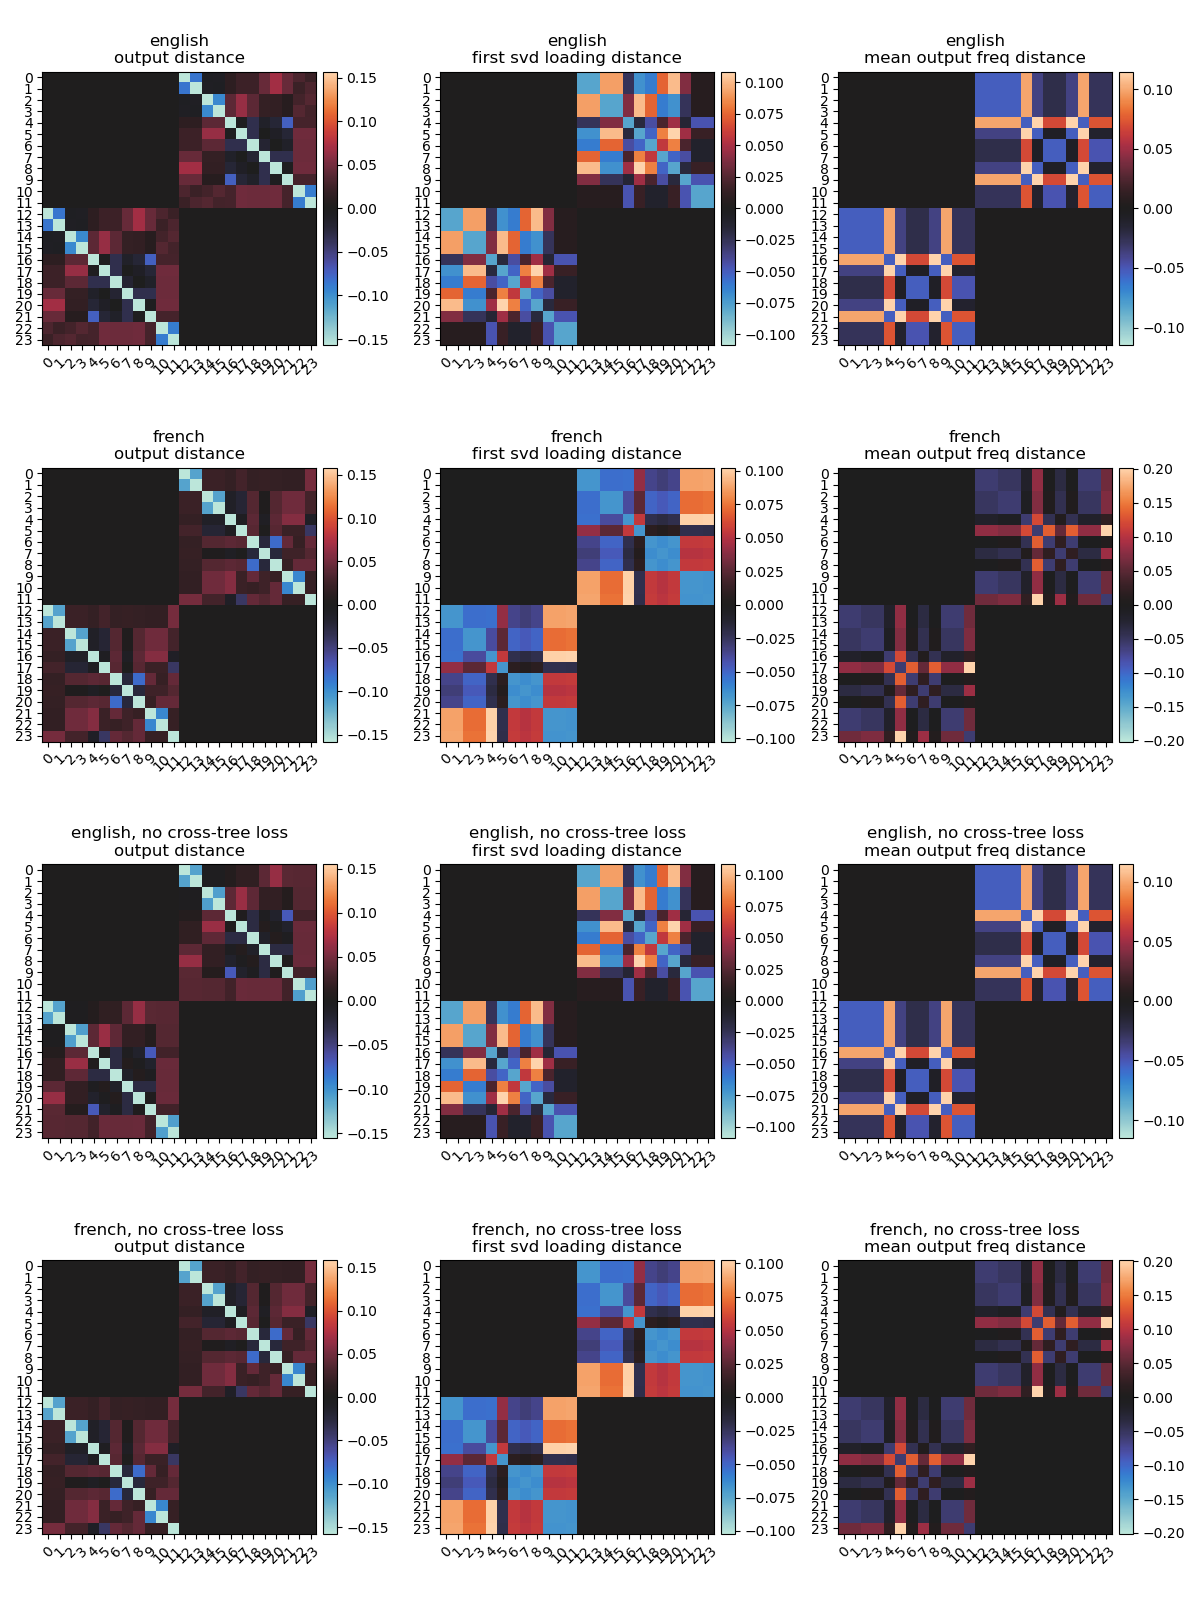

In [20]:
# Try correlating each 2x2 item repr corr matrix with individual SVD and/or attr freq distance, as applicable
colors = [d['color'] for d in list(col_cycle)]
linestyles = ['-', '--', ':']

model_names = {
    'svd': 'output distance',
    'svd_first': 'first svd loading distance',
    'attr_freq': 'mean output freq distance'
}

snap_type = 'person1_hidden'

PEOPLE_PER_TREE = 12

def get_model_corrs(res):
    n_train_domains = res['net_params']['n_train_domains']
    train_items = np.arange(PEOPLE_PER_TREE * n_train_domains)

    tree_id = res['net_params']['trees'][0]
    tree = familytree.get_tree(tree_id)
    p1_mat, _, p2_mat = tree.get_io_mats()
    
    def get_svd_dist_model(modes_to_use):
        """
        Get model that expects off-diagonal blocks to resemble the average SVD distance matrix over all domains
        Now returns a 3D array with a separate model for each run.
        """
        svd_dist = util.center_and_norm_rdm(pa.get_contextfree_item_svd_dist(p1_mat, p2_mat, 1, modes_to_use))
        # tile over full set of trained items (block diagonal will be zeroed later)
        return np.tile(svd_dist, (n_train_domains, n_train_domains))
    
    full_p1_mat = block_diag(*([p1_mat] * n_train_domains))
    full_p2_mat = block_diag(*([p2_mat] * n_train_domains))
    attr_freq_dist_mat = pa.get_attr_freq_dist_mat(full_p1_mat, full_p2_mat)
    
    models = {
        'svd': get_svd_dist_model(slice(None)),
        'svd_first': get_svd_dist_model([0]),
        'attr_freq': util.center_and_norm_rdm(attr_freq_dist_mat)
    }
        
    # set all block diagonal entries to zero - we want to focus on the off-diagonal entries
    offdiag_mask = train_items[np.newaxis, :] // PEOPLE_PER_TREE != train_items[:, np.newaxis] // PEOPLE_PER_TREE
    for model_name in models:
        models[model_name] = np.where(offdiag_mask, models[model_name], 0)
        models[model_name] = util.center_and_norm_rdm(models[model_name])

    return models, net_analysis.get_rdm_projections(res, snap_type, models)

def plot_corr_ci(ax, res, corr, label, color, style):
    mean, (lower, upper) = util.get_mean_and_ci(corr)
    ax.plot(res['snap_epochs'], mean, label=label, color=color, linestyle=style)
    ax.fill_between(res['snap_epochs'], lower, upper, alpha=0.3, color=color, linestyle=style)

# For matrix plots of models
fig1, model_axss = util.auto_subplots(len(curr_sets), len(model_names))

fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.set_title(f'Correlation of {snap_type} {load_settings["dist_metric"]} \n' +
              'distances with SVD and attribute frequency models')

for (res_name, res), col, model_axs in zip(curr_sets.items(), colors, model_axss):
    label = re.search(r'(, no cross-tree loss|)\)\\(\w+) ', res_name).expand(r'\2\1')
    models, res_corrs = get_model_corrs(res) 
    for (model_type, model), ls, model_ax in zip(models.items(), linestyles, model_axs):
        util.plot_matrix_with_labels(model_ax, model, [str(k) for k in range(len(model))])
        model_ax.set_title(f'{label}\n{model_names[model_type]}')
        
        plot_corr_ci(ax2, res, res_corrs[model_type], label + f', corr. with {model_names[model_type]} model', col, ls)

util.outside_legend(ax2)
fig1.tight_layout()
fig2.tight_layout()
plt.show()